In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.mumps.Mumps

# set up models and mesh

In [3]:
rho_back = 150
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_dips = np.r_[0, 15, 30, 45]
target_z = np.r_[-70, -40]

In [4]:
tx_height = np.r_[30]

rx_x = (np.linspace(-500, 500, 51) + 5)[::10]
rx_y = np.r_[0]
rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

array([-495., -295.,  -95.,  105.,  305.,  505.])

In [5]:
base_cell_width = 10
domain_extent = 8000

n_base_cells = 2 ** int(
    np.ceil(np.log(domain_extent / base_cell_width) / np.log(2.0))
)  # needs to be powers of 2 for the tree mesh

h = [(base_cell_width, n_base_cells)]
mesh = discretize.TreeMesh([h, h, h], origin="CCC", diagonal_balance=True)

# refine near transmitters and receivers
mesh.refine_points(
    rx_locs, level=-1, padding_cells_by_level=[2, 2, 4], 
    finalize=False, diagonal_balance=True
)

# Refine core region of the mesh 

bounding_points = np.array([
    [rx_x.min(), rx_y.min(), target_z.min()*3 - base_cell_width * 4], 
    [rx_x.max(), rx_y.max(), 0],
])
mesh.refine_bounding_box(
    bounding_points, level=-1, 
    diagonal_balance=True, finalize=False, padding_cells_by_level=[2, 4, 8]
)

mesh.finalize()

In [6]:
mesh

OcTreeMesh,0.01% filled
Level,Number of cells
3,448
4,416
5,480
6,1296
7,3744
8,32328
9,14428
10,27424
Total,80564


In [7]:
def dipping_target_indices(
    mesh, target_x_center, target_z_center, dip, target_thickness, target_xlim=None, target_ylim=None, target_zlim=None
): 
    """
    add a dipping target to the model. For now assumes the target dips in the x-direction
    """
    x_center = np.mean(target_x)
    slope = np.tan(-dip*np.pi/180)
    target_z = target_z_center + target_thickness / 2 * np.r_[-1, 1]
    
    z_bottom = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.min()
    z_top = (mesh.cell_centers[:, 0] - target_x_center) * slope + target_z.max()

    indices = (
        (mesh.cell_centers[:, 2] >= z_bottom) &
        (mesh.cell_centers[:, 2] <= z_top) 
    )

    if target_xlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 0] >= target_xlim.min()) &
            (mesh.cell_centers[:, 0] <= target_xlim.max())
        )
    if target_ylim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 1] >= target_ylim.min()) &
            (mesh.cell_centers[:, 1] <= target_ylim.max())
        )
    if target_zlim is not None: 
        indices = indices & (
            (mesh.cell_centers[:, 2] >= target_zlim.min()) &
            (mesh.cell_centers[:, 2] <= target_zlim.max())
        )
    return indices

In [8]:
models = {}

target_x = np.r_[-400, 500]
target_y = np.r_[-400, 500]
target_thickness = 45

# background model
background = np.ones(mesh.n_cells) * sigma_air
background[mesh.cell_centers[:, 2] < 0] = sigma_back
models["background"] = background

for dip in target_dips:
    model = background.copy()
    indices = dipping_target_indices(
        mesh, target_x_center=-100, target_z_center=-60, 
        target_thickness=target_thickness, dip=dip, 
        target_xlim=np.r_[-400, 400], 
        target_ylim=np.r_[-400, 400],
        target_zlim=np.r_[-200, -20]
    )
    model[indices] = sigma_target
    models[f"target_{dip}"] = model



In [9]:
indices

array([False, False, False, ..., False, False, False], shape=(80564,))

In [10]:
model_keys = list(models.keys())
model_keys

['background', 'target_0', 'target_15', 'target_30', 'target_45']

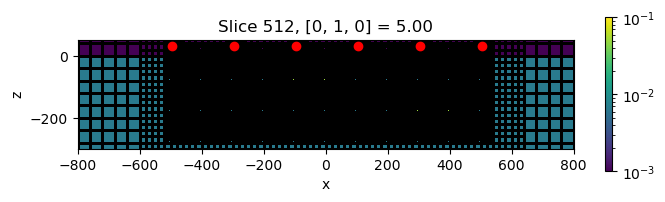

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

plt.colorbar(
    mesh.plot_slice(
        models["target_15"], 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(800*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)

In [16]:
active_cells_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

In [17]:
rx_times = np.logspace(np.log10(1e-4), np.log10(3e-3), 20)

In [18]:
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

survey = tdem.Survey(source_list)

In [19]:
# set up the survey

time_steps = [
    (1e-5, 40), (3e-5, 20), (1e-4, 20), (3e-4, 20)
]

In [20]:
global_sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh,
    survey=survey,
    time_steps=time_steps,
    solver=Solver,
    sigmaMap=maps.ExpMap() * active_cells_map
)

In [31]:
refine_depth = 180 # refine our local mesh to 200m 
mesh_list = []

for src in source_list: 
    mesh_local = discretize.TreeMesh(mesh.h, origin=mesh.origin, diagonal_balance=True)
    
    # refine near transmitters and receivers
    refine_points = discretize.utils.ndgrid(
        np.r_[src.location[0]], np.r_[src.location[1]], np.linspace(-refine_depth, src.location[2], 40)
    )
    mesh_local.refine_points(
        refine_points, level=-2, padding_cells_by_level=[2, 4, 4], 
        finalize=True, diagonal_balance=True
    )
    mesh_list.append(mesh_local)

In [32]:
mesh_list[1]

OcTreeMesh: 0.00% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       448            ---------------------------   --------------------
  4   :       442         x:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  5   :       412         y:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  6   :       848         z:    -5120.0   ,   5120.0          20.0   ,   1280.0  
  7   :      2474      
  8   :      1664      
  9   :       384      
-----------------------
Total :      6672

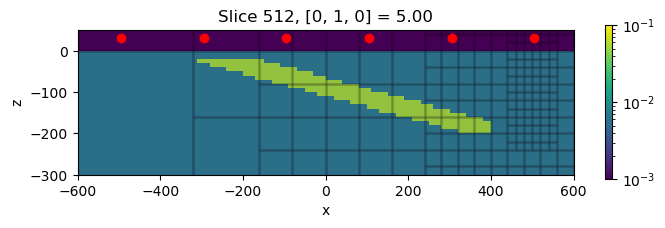

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

mesh_local = mesh_list[-1]

plt.colorbar(
    mesh.plot_slice(
        models["target_15"], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)
mesh_local.plot_slice(
    np.ones(mesh_local.n_cells), 
    # grid=True, 
    normal="y",
    grid_opts={"color":"k", "lw":1},
    pcolor_opts={"alpha":0.1},
    ax=ax
)
ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)


In [34]:
mappings = []
sims = []

for ii, local_mesh in enumerate(mesh_list):

    tile_map = maps.TileMap(mesh, active_cells_map.active_cells, local_mesh)
    mappings.append(tile_map)
    
    local_actmap = maps.InjectActiveCells(
        local_mesh, 
        active_cells=tile_map.local_active, 
        value_inactive=np.log(1e-8)
    )
    
    local_survey = tdem.Survey([survey.source_list[ii]])
    sims.append(tdem.simulation.Simulation3DElectricField(
            mesh=local_mesh,
            survey=local_survey,
            time_steps=time_steps,
            solver=Solver,
            sigmaMap=maps.ExpMap() * local_actmap
        )
    )

# client = Client()

sim = MultiprocessingMetaSimulation(sims, mappings, n_processes=4)
# sim = DaskMetaSimulation(sims, mappings)


In [35]:
log_conductivity_models = {}

for key, val in models.items():
    log_conductivity_models[key] = np.log(val[active_cells_map.active_cells])

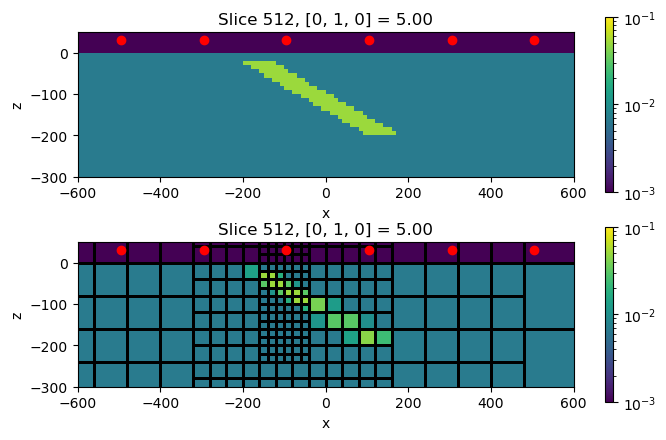

In [36]:
ind = 2
key = model_keys[3]
m_plot = sims[ind].sigmaMap * sim.mappings[ind] * log_conductivity_models[key]

fig, ax = plt.subplots(2, 1, figsize=(8, 5)) 

mesh_local = mesh_list[ind]

plt.colorbar(
    mesh.plot_slice(
        models[key], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax[0])[0], 
    ax=ax[0]
)

plt.colorbar(
    mesh_local.plot_slice(
        m_plot, 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax[1])[0], 
    ax=ax[1]
)

for a in ax:
    a.set_xlim(600*np.r_[-1, 1])
    a.set_ylim(np.r_[-300, 50])
    
    a.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
    a.set_aspect(1)



In [37]:
model_keys

['background', 'target_0', 'target_15', 'target_30', 'target_45']

In [38]:
%%time 
key = model_keys[0]
model = log_conductivity_models[key]
# fields = sim.fields(model)
dpred = sim.dpred(model)
print(dpred)
# sim.join()

/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)
/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)
/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning 

[-2.24031827e-08 -1.41253330e-08 -8.98973918e-09 -5.71865599e-09
 -3.66774171e-09 -2.35288024e-09 -1.51088405e-09 -9.70524791e-10
 -6.31956676e-10 -4.15643048e-10 -2.71107422e-10 -1.75835680e-10
 -1.13605666e-10 -7.40861753e-11 -4.92985095e-11 -3.23909345e-11
 -2.10495721e-11 -1.35408125e-11 -8.68383972e-12 -5.54115231e-12
 -2.24234872e-08 -1.41406813e-08 -9.00069571e-09 -5.72557076e-09
 -3.67145126e-09 -2.35446551e-09 -1.51131238e-09 -9.70445312e-10
 -6.31734449e-10 -4.15431326e-10 -2.70947573e-10 -1.75714276e-10
 -1.13487919e-10 -7.39502183e-11 -4.91543440e-11 -3.22609453e-11
 -2.09516973e-11 -1.34790151e-11 -8.64876001e-12 -5.51954090e-12
 -2.24025601e-08 -1.41252133e-08 -8.98996341e-09 -5.71905802e-09
 -3.66818636e-09 -2.35330985e-09 -1.51131136e-09 -9.70988514e-10
 -6.32458013e-10 -4.16127015e-10 -2.71510891e-10 -1.76123353e-10
 -1.13783868e-10 -7.41894924e-11 -4.93618291e-11 -3.24326734e-11
 -2.10790869e-11 -1.35611370e-11 -8.69524860e-12 -5.54411442e-12
 -2.24216298e-08 -1.41394

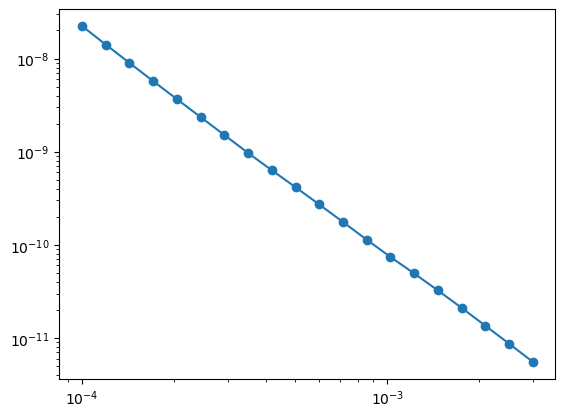

In [39]:
plt.loglog(rx_times, -dpred[:len(rx_times)], "-o")

In [40]:
rx_times

array([0.0001    , 0.0001196 , 0.00014305, 0.00017109, 0.00020463,
       0.00024475, 0.00029272, 0.00035011, 0.00041874, 0.00050083,
       0.00059901, 0.00071643, 0.00085688, 0.00102485, 0.00122576,
       0.00146605, 0.00175344, 0.00209718, 0.00250829, 0.003     ])